In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import pickle

import dynesty
from dynesty import plotting as dyplot
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar
from tqdm.auto import trange

from pydd.analysis import (
    calculate_SNR,
    calculate_SNR_cut,
    get_match_pads,
    loglikelihood_fft,
)
from pydd.binary import (
    DynamicDress,
    MSUN,
    PC,
    YR,
    get_f_isco,
    get_M_chirp,
    get_f_range,
    get_m_1,
    get_rho_6,
    get_rho_s,
)
# from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET
# from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE
from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO
# from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

Array = jnp.ndarray
T_OBS = 5 * YR
SNR_THRESH = 12.0
GAMMA_S_PBH = jnp.array(9 / 4)

## Setup

In [98]:
get_rho_6(1.798e4 * MSUN / PC**3, 1 * MSUN, GAMMA_S_PBH) / (1e16 * MSUN / PC**3)

DeviceArray(0.00300738, dtype=float64, weak_type=True)

In [73]:
def get_signal_system():
    M_1 = jnp.array(1 * MSUN)
    M_2 = jnp.array(1e-3 * MSUN)
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    GAMMA_S = GAMMA_S_PBH
    RHO_6 = 0.5345e16 * MSUN / PC ** 3
    TT_C = jnp.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = jnp.array(0.0)
    _DD_D = DynamicDress(
        GAMMA_S,
        RHO_6,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=jnp.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_DD_D, T_OBS)
    FS = jnp.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 10_000
    )

    # Get dL
    _fn = jax.jit(
        lambda dL: calculate_SNR(
            DynamicDress(
                _DD_D.gamma_s,
                _DD_D.rho_6,
                _DD_D.M_chirp,
                _DD_D.q,
                _DD_D.Phi_c,
                _DD_D.tT_c,
                dL,
                _DD_D.f_c,
            ),
            FS,
            S_n,
        )
    )
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    DD_D = DynamicDress(
        _DD_D.gamma_s,
        _DD_D.rho_6,
        _DD_D.M_chirp,
        _DD_D.q,
        _DD_D.Phi_c,
        _DD_D.tT_c,
        DL,
        _DD_D.f_c,
    )

    return DD_D, F_RANGE_D

In [74]:
DD_D, F_RANGE_D = get_signal_system()
FS = jnp.linspace(*F_RANGE_D, 10_000)
PAD_LOW, PAD_HIGH = get_match_pads(FS)

## 1D

In [130]:
def ptform(u):
    assert u.shape == (1,)
    v_m = jnp.array([1e-10])
    return 2 * v_m * (u - 0.5)

def unpack(x):
    dMc_MSUN = x[0]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, DD_D.gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, DD_D.gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(
        DD_D.gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c
    )


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [131]:
xs = []
lls = []
for _ in trange(100):
    xs.append(ptform(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Likelihood')

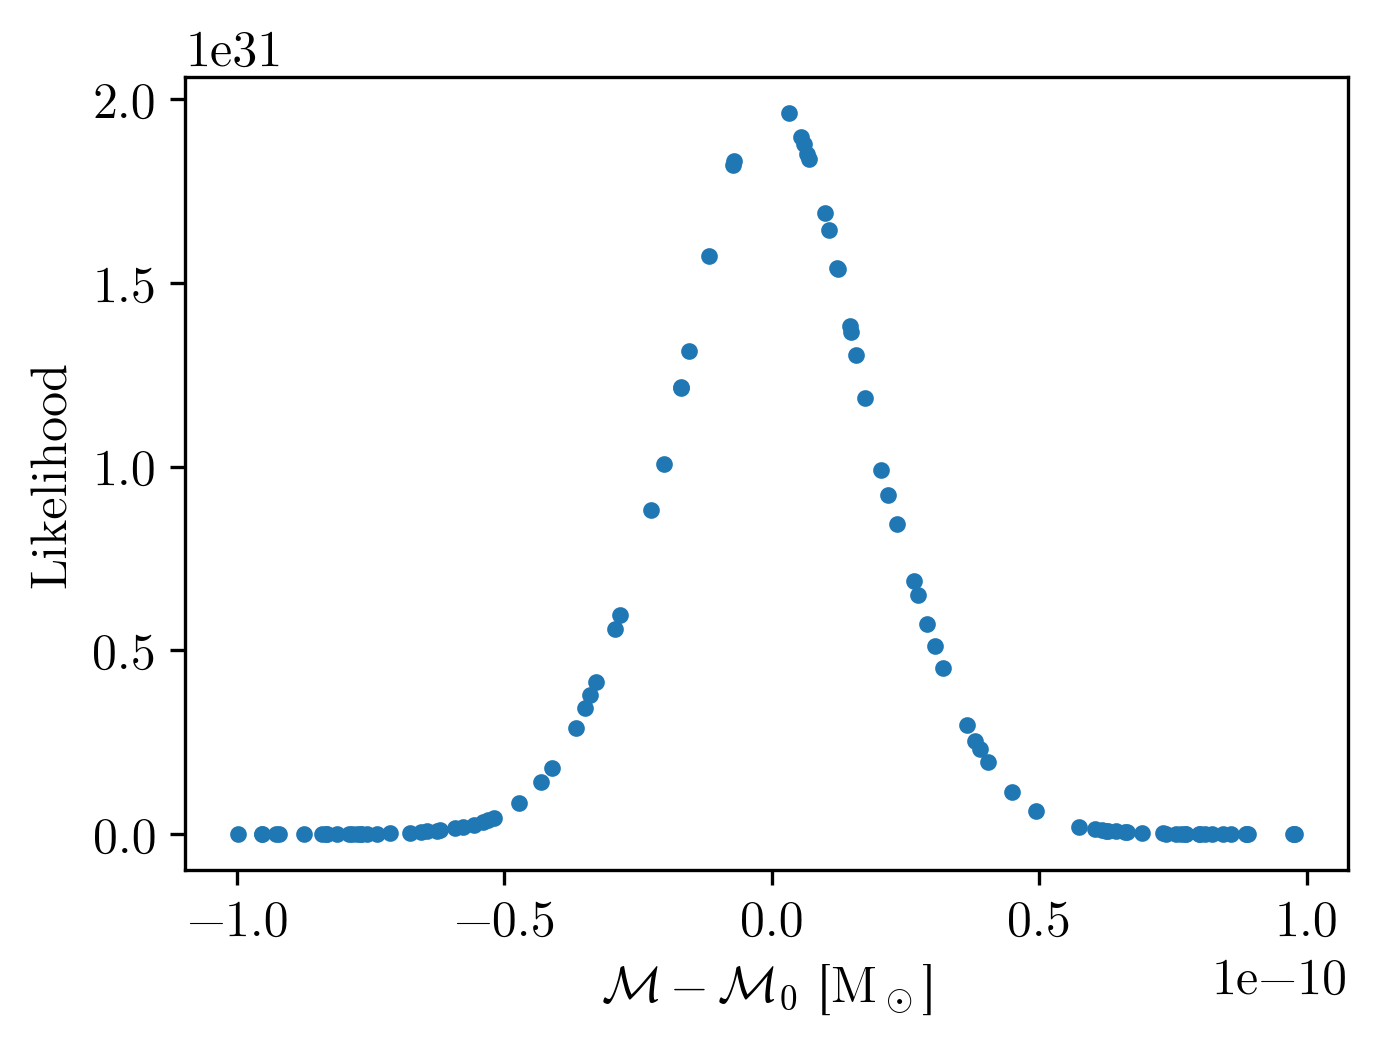

In [137]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")

## 2D

In [75]:
def ptform_et(u):
    assert u.shape == (2,)
    v_m = jnp.array([3e-10, 2e-7])
    return 2 * v_m * (u - 0.5)


def ptform_ce(u):
    assert u.shape == (2,)
    v_m = 10 * jnp.array([3e-10, 2e-7])
    return 2 * v_m * (u - 0.5)


def ptform_aLIGO(u):
    assert u.shape == (2,)
    v_m = 10 * jnp.array([3e-10, 2e-7])
    return 2 * v_m * (u - 0.5)


def unpack(x):
    dMc_MSUN = x[0]
    dg_s = x[1]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = DD_D.gamma_s + dg_s

    m_1 = get_m_1(Mc, DD_D.q)
    rho_s = get_rho_s(DD_D.rho_6, m_1, gamma_s)
    rho_6 = get_rho_6(rho_s, m_1, gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [76]:
xs = []
lls = []
for _ in trange(500):
    xs.append(ptform_aLIGO(np.random.rand(2)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/500 [00:00<?, ?it/s]

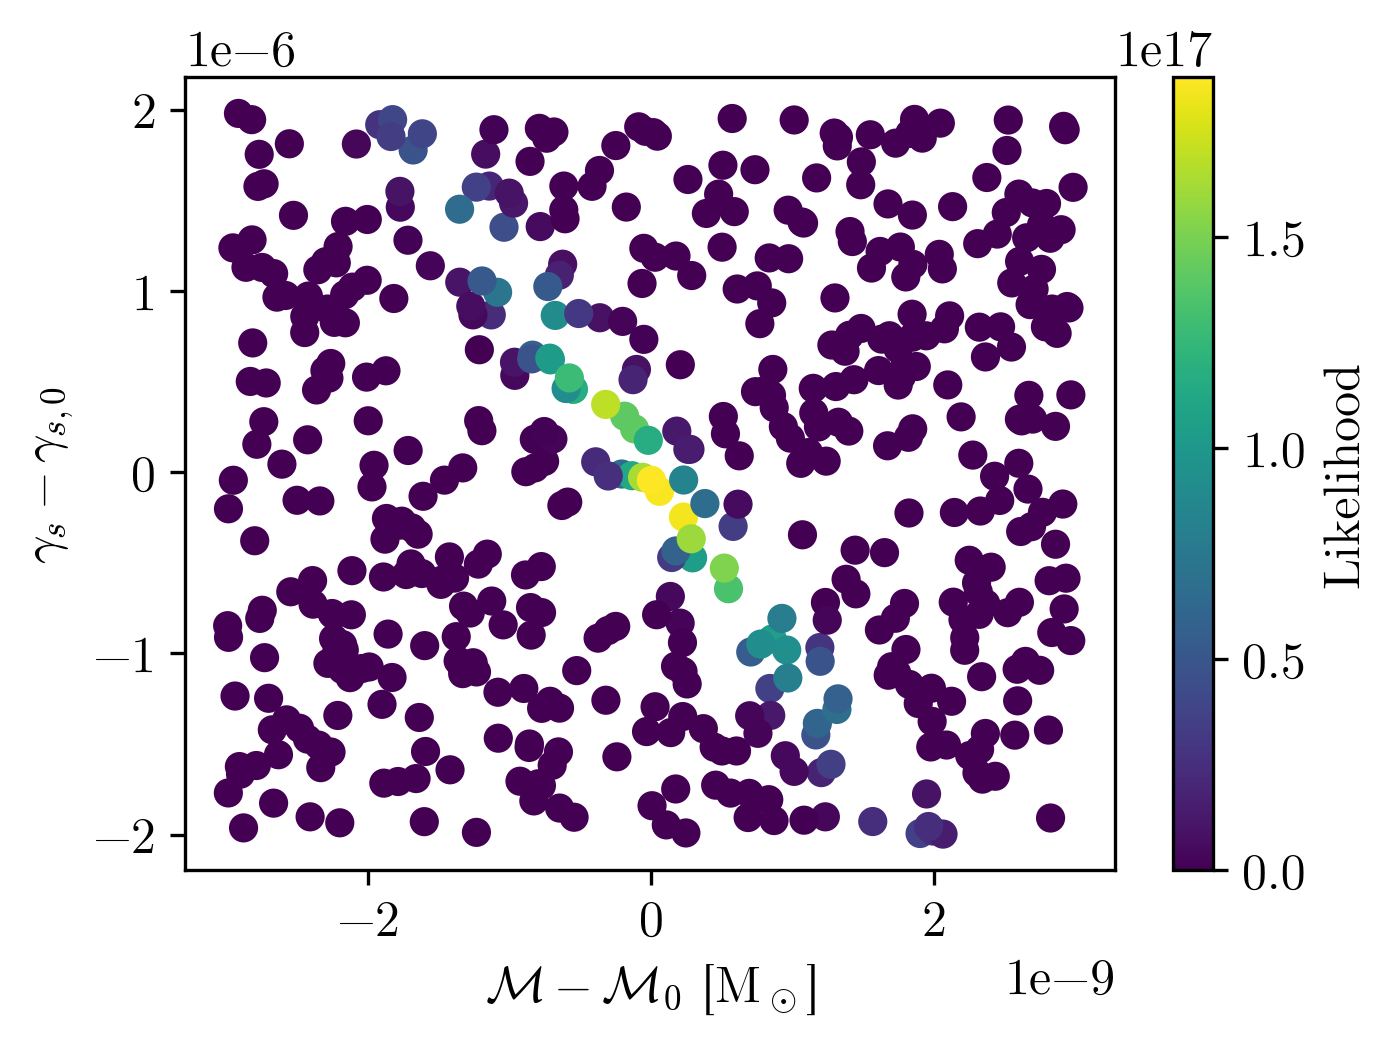

In [77]:
# plt.scatter(*xs.T, c=lls)
plt.scatter(*xs.T, c=jnp.exp(lls - lls.min()))
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel(r"$\gamma_s - \gamma_{s,0}$")
plt.colorbar(label="Likelihood")

## 3D

In [6]:
def ptform(u):
    assert u.shape == (3,)
    v_m = jnp.array([1.5e-6, 3e-5, 2e-3])
    return 2 * v_m * (u - 0.5)


def unpack(x):
    dMc_MSUN = x[0]
    dg_s = x[1]
    dr_6_15_MSUN_PC3 = x[2]
    Mc = DD_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = DD_D.gamma_s + dg_s
    rho_6 = DD_D.rho_6 + dr_6_15_MSUN_PC3 * 1e15 * MSUN / PC**3

    m_1 = get_m_1(Mc, DD_D.q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [124]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 3, nlive=500)
sampler.run_nested()
results = sampler.results

9340it [38:00,  4.10it/s, +500 | bound: 213 | nc: 1 | ncall: 195834 | eff(%):  5.025 | loglstar:   -inf < 72.048 <    inf | logz: 54.125 +/-  0.267 | dlogz:  0.001 >  0.509]


In [127]:
# with open(f"ns/earth-based-ns-3d.pkl", "wb") as output:
#     pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

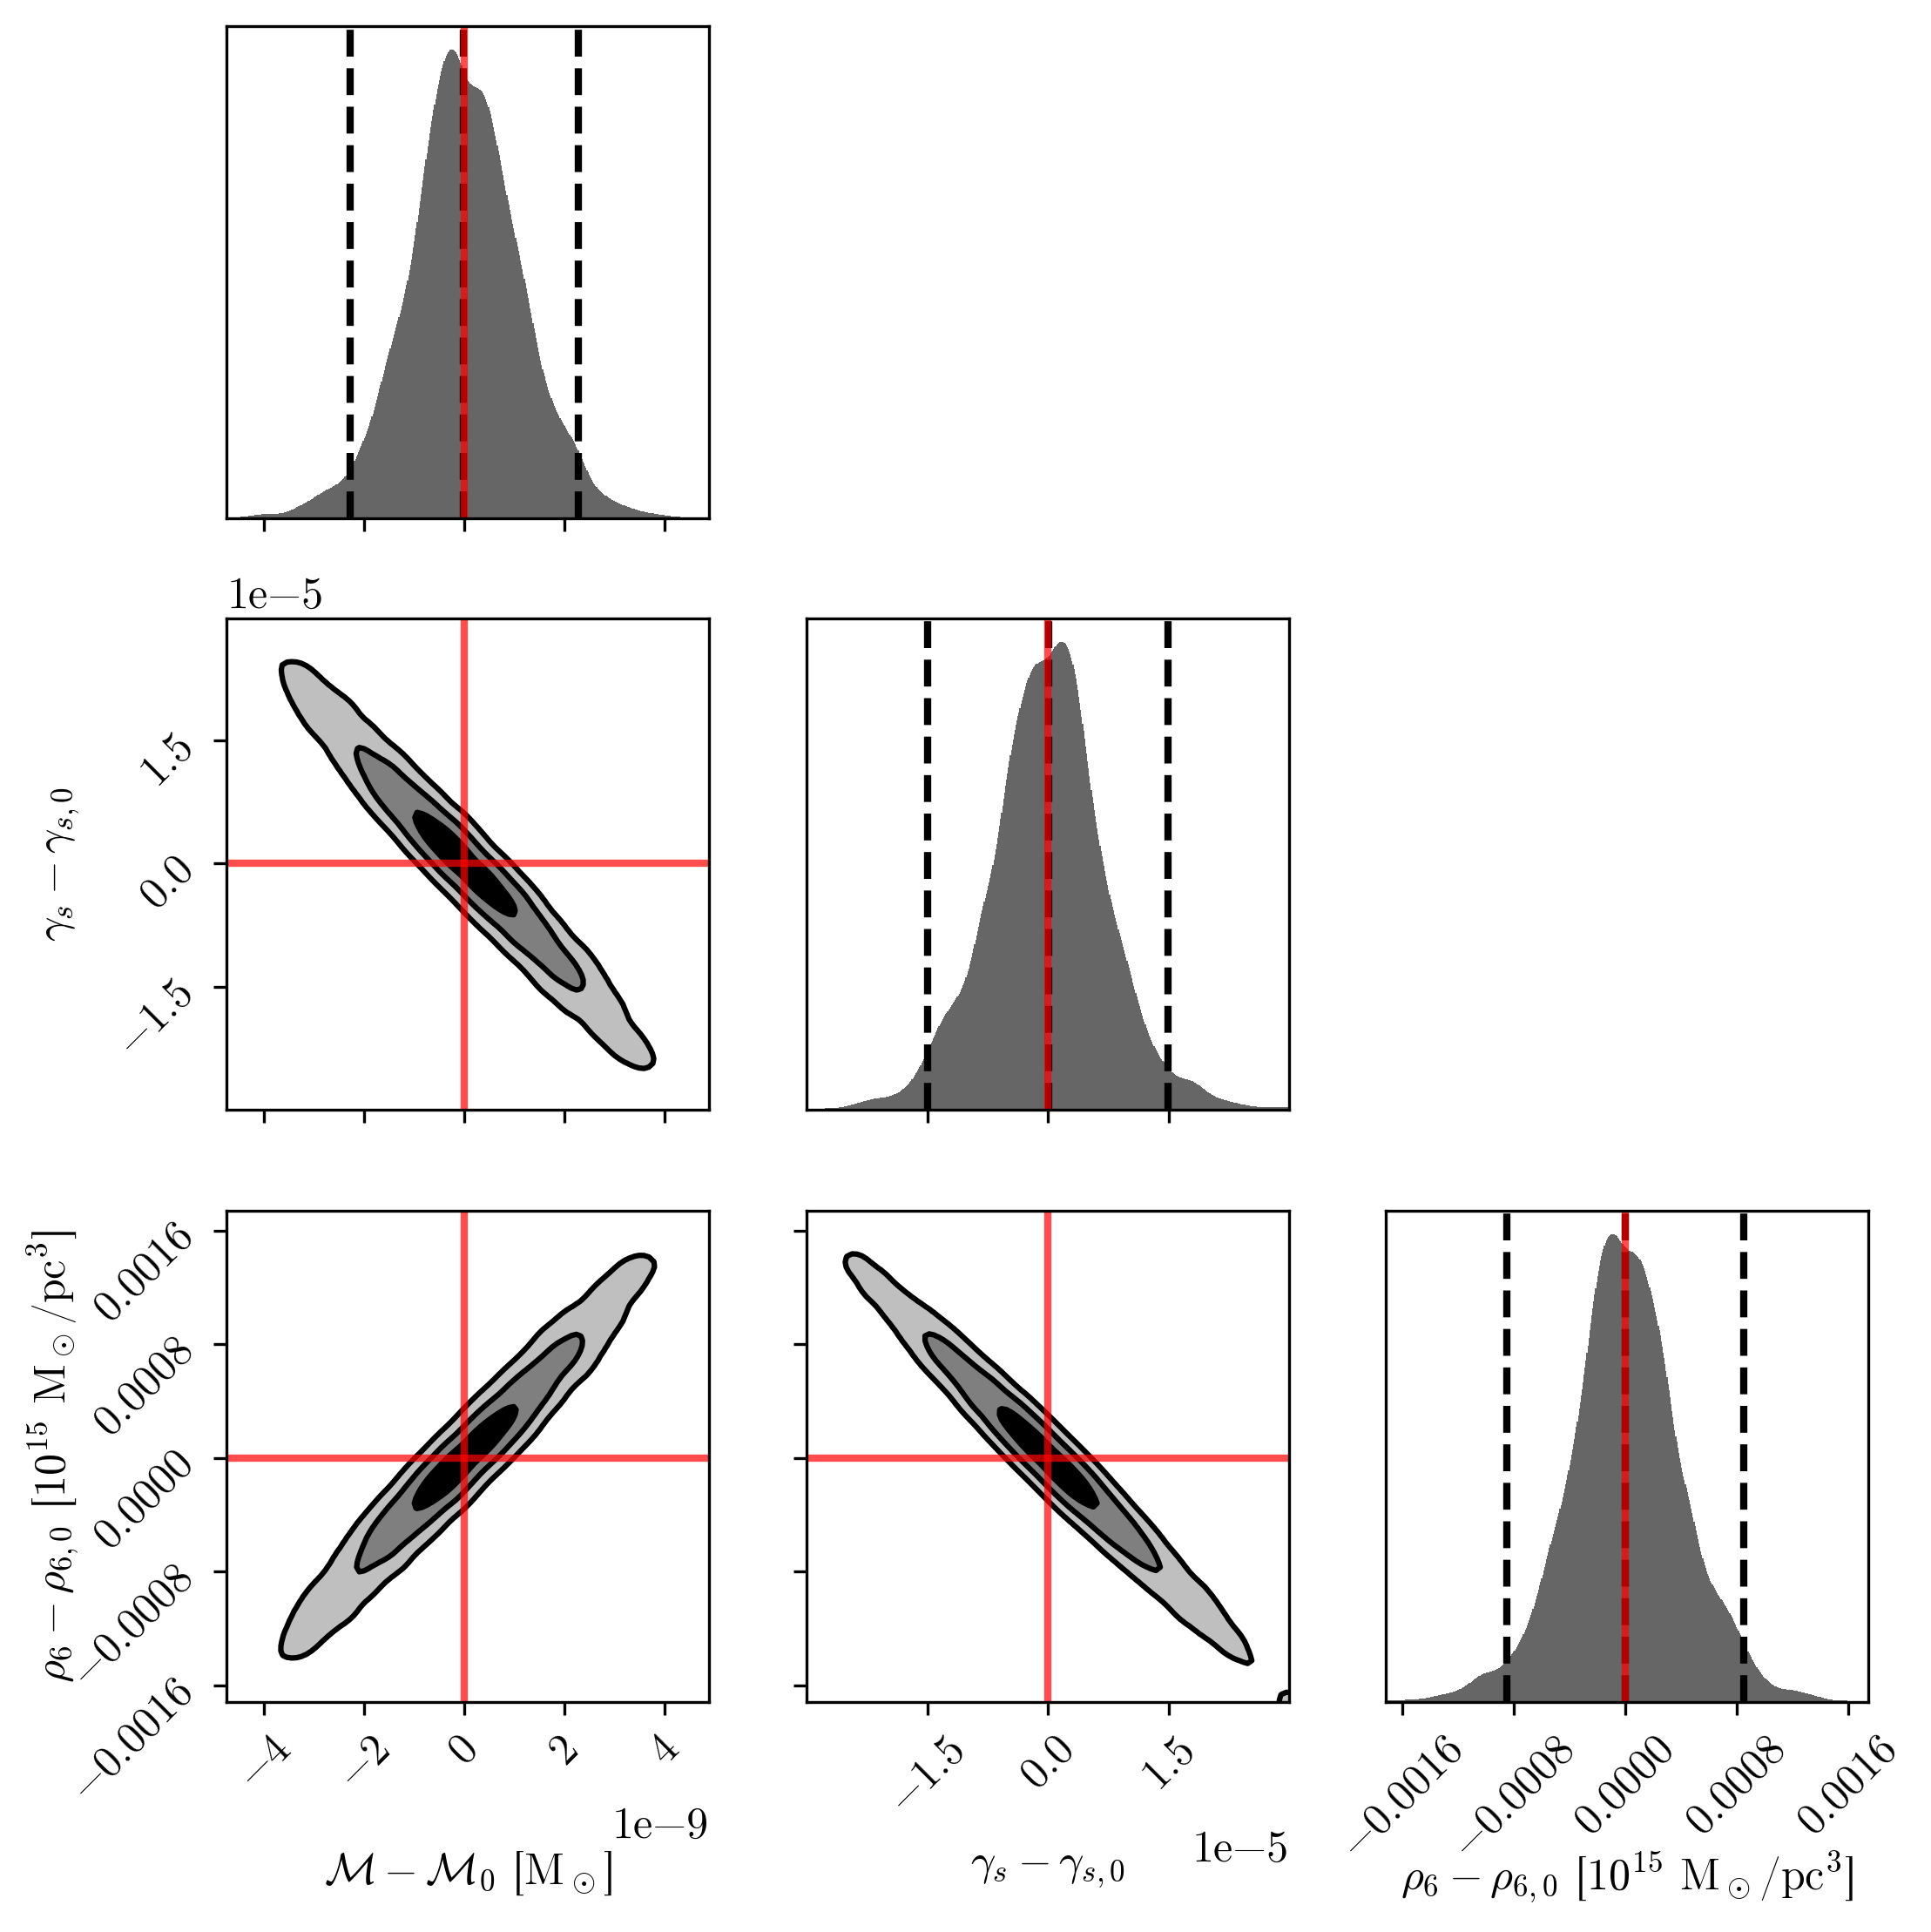

In [130]:
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\gamma_s - \gamma_{s,0}$",
    r"$\rho_6 - \rho_{6,0}$ [$10^{15}$ M$_\odot$/pc$^3$]",
)
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0)
)
fig.tight_layout()

Random sampling. Very inefficient in >2D.

In [5]:
from mpl_toolkits import mplot3d

In [107]:
xs = []
lls = []
for _ in trange(100_000):
    xs.append(ptform(np.random.rand(3)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)
ls = jnp.exp(lls)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [108]:
def get_marginal_1d(xs, ls, dim):
    edges = np.histogram(xs[:, dim])[1]

    n = len(edges) - 1
    vals = np.zeros((n,))
    ns = np.zeros((n,))
    for i in range(n):
        idxs = (xs[:, dim] >= edges[i]) & (xs[:, dim] <= edges[i + 1])
        vals[i] = ls[idxs].sum()
        ns[i] = idxs.sum()

    return (
        jnp.array(0.5 * (edges[1:] + edges[:-1])),
        jnp.array(vals) / vals.sum(),
        jnp.array(ns),
    )


def get_marginal_2d(xs, ls, x_dim, y_dim):
    xedges, yedges = np.histogram2d(xs[:, x_dim], xs[:, y_dim])[1:]

    nx = len(xedges) - 1
    ny = len(yedges) - 1
    vals = np.zeros((nx, ny))
    ns = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            idxs = (
                (xs[:, x_dim] >= xedges[i])
                & (xs[:, x_dim] <= xedges[i + 1])
                & (xs[:, y_dim] >= yedges[j])
                & (xs[:, y_dim] <= yedges[j + 1])
            )
            vals[i, j] = ls[idxs].sum()
            ns[i, j] = idxs.sum()

    return (
        jnp.array(0.5 * (xedges[1:] + xedges[:-1])),
        jnp.array(0.5 * (yedges[1:] + yedges[:-1])),
        jnp.array(vals) / vals.sum(),
        jnp.array(ns),
    )


def plot_marginals(xs, ls, labels, vmax=None):
    n_dims = xs.shape[1]
    fig, axes = plt.subplots(n_dims, n_dims, figsize=(3 * n_dims, 3 * n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            if i == j:
                axes[i, j].plot(get_marginal_1d(xs, ls, i)[1])
            elif i > j:
                axes[i, j].imshow(get_marginal_2d(xs, ls, i, j)[2], vmax=vmax)
            else:
                axes[i, j].axis("off")

    for i, ax in enumerate(axes[-1, :]):
        ax.set_xlabel(labels[i])

    for i, ax in enumerate(axes[:, 0]):
        ax.set_ylabel(labels[i])

    fig.tight_layout()
    return fig, axes

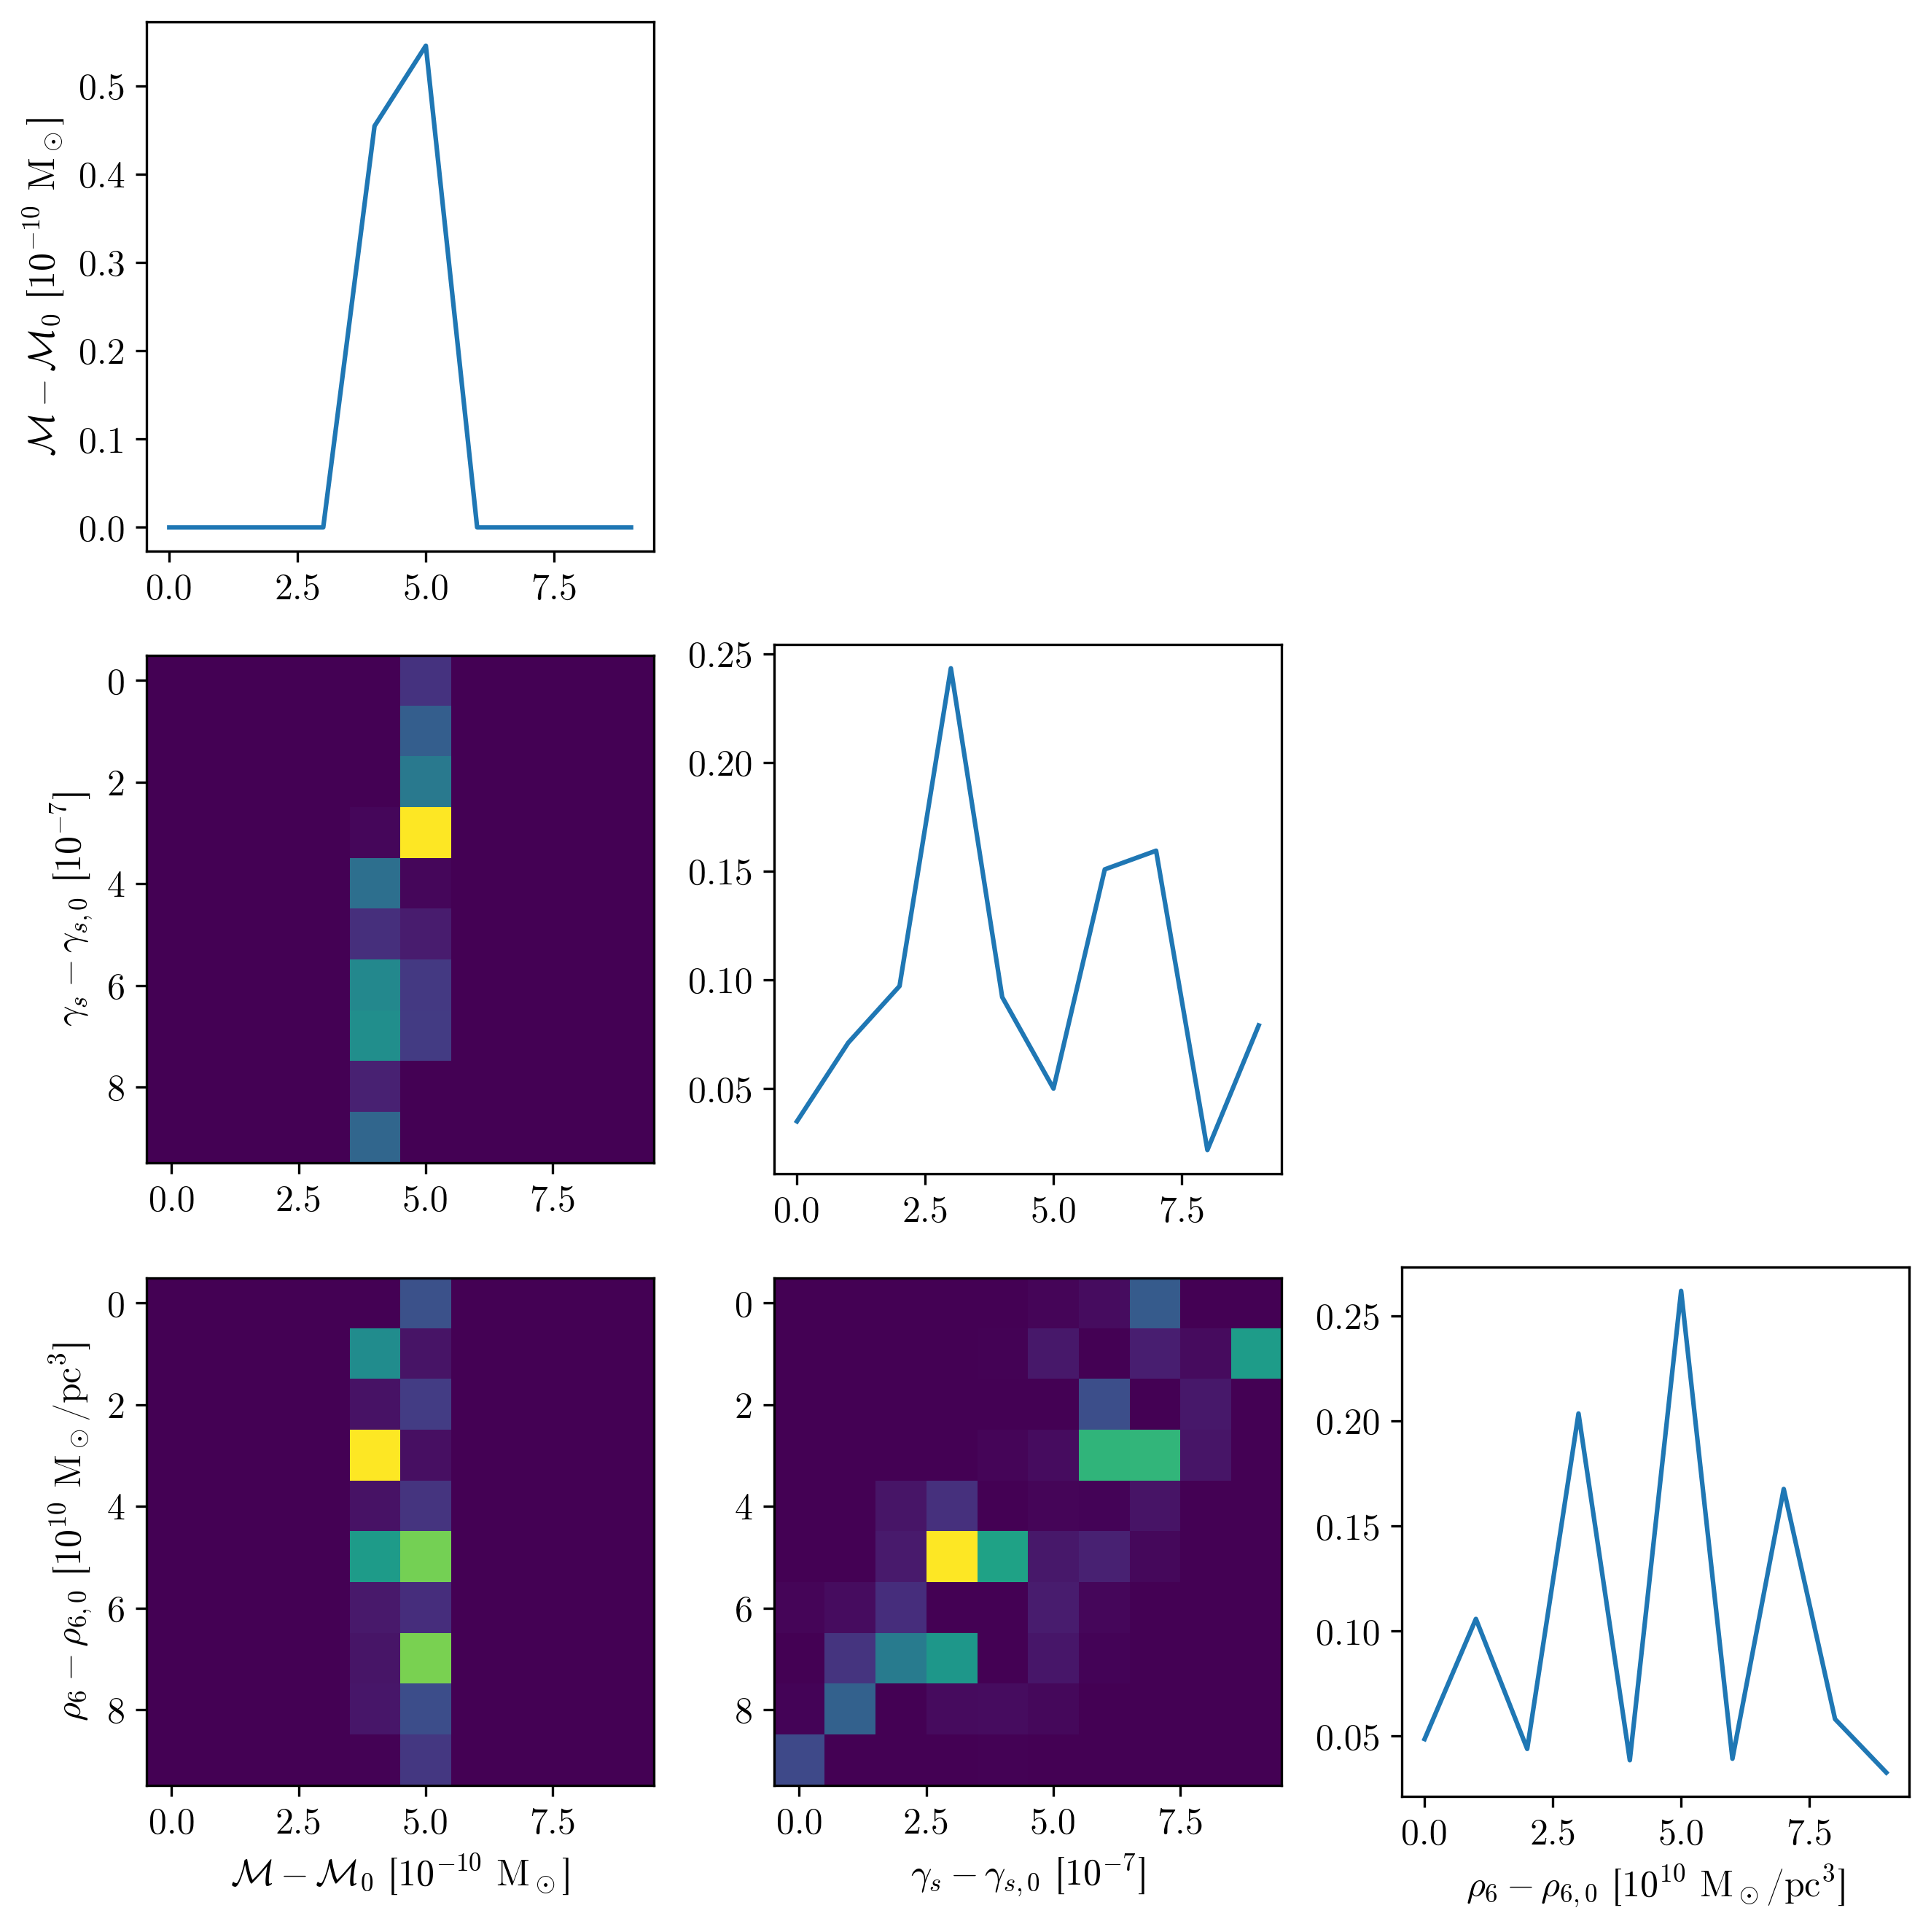

In [109]:
plot_marginals(xs, ls, labels, vmax=None);

## 4D

In [89]:
def ptform_et(u):
    assert u.shape == (4,)
    central = jnp.array(
        [
            DD_D.gamma_s,
            DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
            DD_D.M_chirp / MSUN,
            jnp.log10(DD_D.q),
        ]
    )
    delta = jnp.array([6e-5, 1e-4, 8e-9, 8e-4])
    v_low = central - jnp.array([4, 3, 6, 4]) * delta
    v_high = central + jnp.array([4, 3, 6, 4]) * delta
    return v_low + (v_high - v_low) * u


def ptform_ce(u):
    assert u.shape == (4,)
    central = jnp.array(
        [
            DD_D.gamma_s,
            DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
            DD_D.M_chirp / MSUN,
            jnp.log10(DD_D.q),
        ]
    )
    delta = jnp.array([6e-5, 1e-4, 8e-9, 8e-4])
    v_low = central - 10 * jnp.array([4, 3, 6, 4]) * delta
    v_high = central + 10 * jnp.array([4, 3, 6, 4]) * delta
    return v_low + (v_high - v_low) * u


def ptform_aLIGO(u):
    assert u.shape == (4,)
    central = jnp.array(
        [
            DD_D.gamma_s,
            DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
            DD_D.M_chirp / MSUN,
            jnp.log10(DD_D.q),
        ]
    )
    delta = jnp.array([1.2e-4, 5e-4, 1.6e-8, 8e-4])
    v_low = central - 20 * jnp.array([4, 3, 6, 4]) * delta
    v_high = central + 20 * jnp.array([4, 3, 6, 4]) * delta
    return v_low + (v_high - v_low) * u


def unpack(x):
    gamma_s, rho_6T, Mc_MSUN, log10_q = x
    rho_6 = rho_6T * 1e16 * MSUN / PC ** 3
    M_chirp = Mc_MSUN * MSUN
    q = 10 ** log10_q

    m_1 = get_m_1(M_chirp, q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, M_chirp, q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c)


@jax.jit
def get_ll_fft(x):
    dd_h = unpack(x)
    return loglikelihood_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [90]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform_aLIGO, 4, nlive=2000)
sampler.run_nested()
# sampler = dynesty.DynamicNestedSampler(get_ll_fft, ptform, 4, nlive=2000)
# sampler.run_nested(nlive_init=500, nlive_batch=100)
results = sampler.results

42815it [34:54, 20.44it/s, +2000 | bound: 48 | nc: 1 | ncall: 212698 | eff(%): 21.070 | loglstar:   -inf < 71.713 <    inf | logz: 49.155 +/-  0.214 | dlogz:  0.002 >  2.009]


In [91]:
with open(f"ns/ns-aLIGO-4d.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [92]:
# with open(f"ns/ns-ce-4d.pkl", "rb") as infile:
#     results = pickle.load(infile)

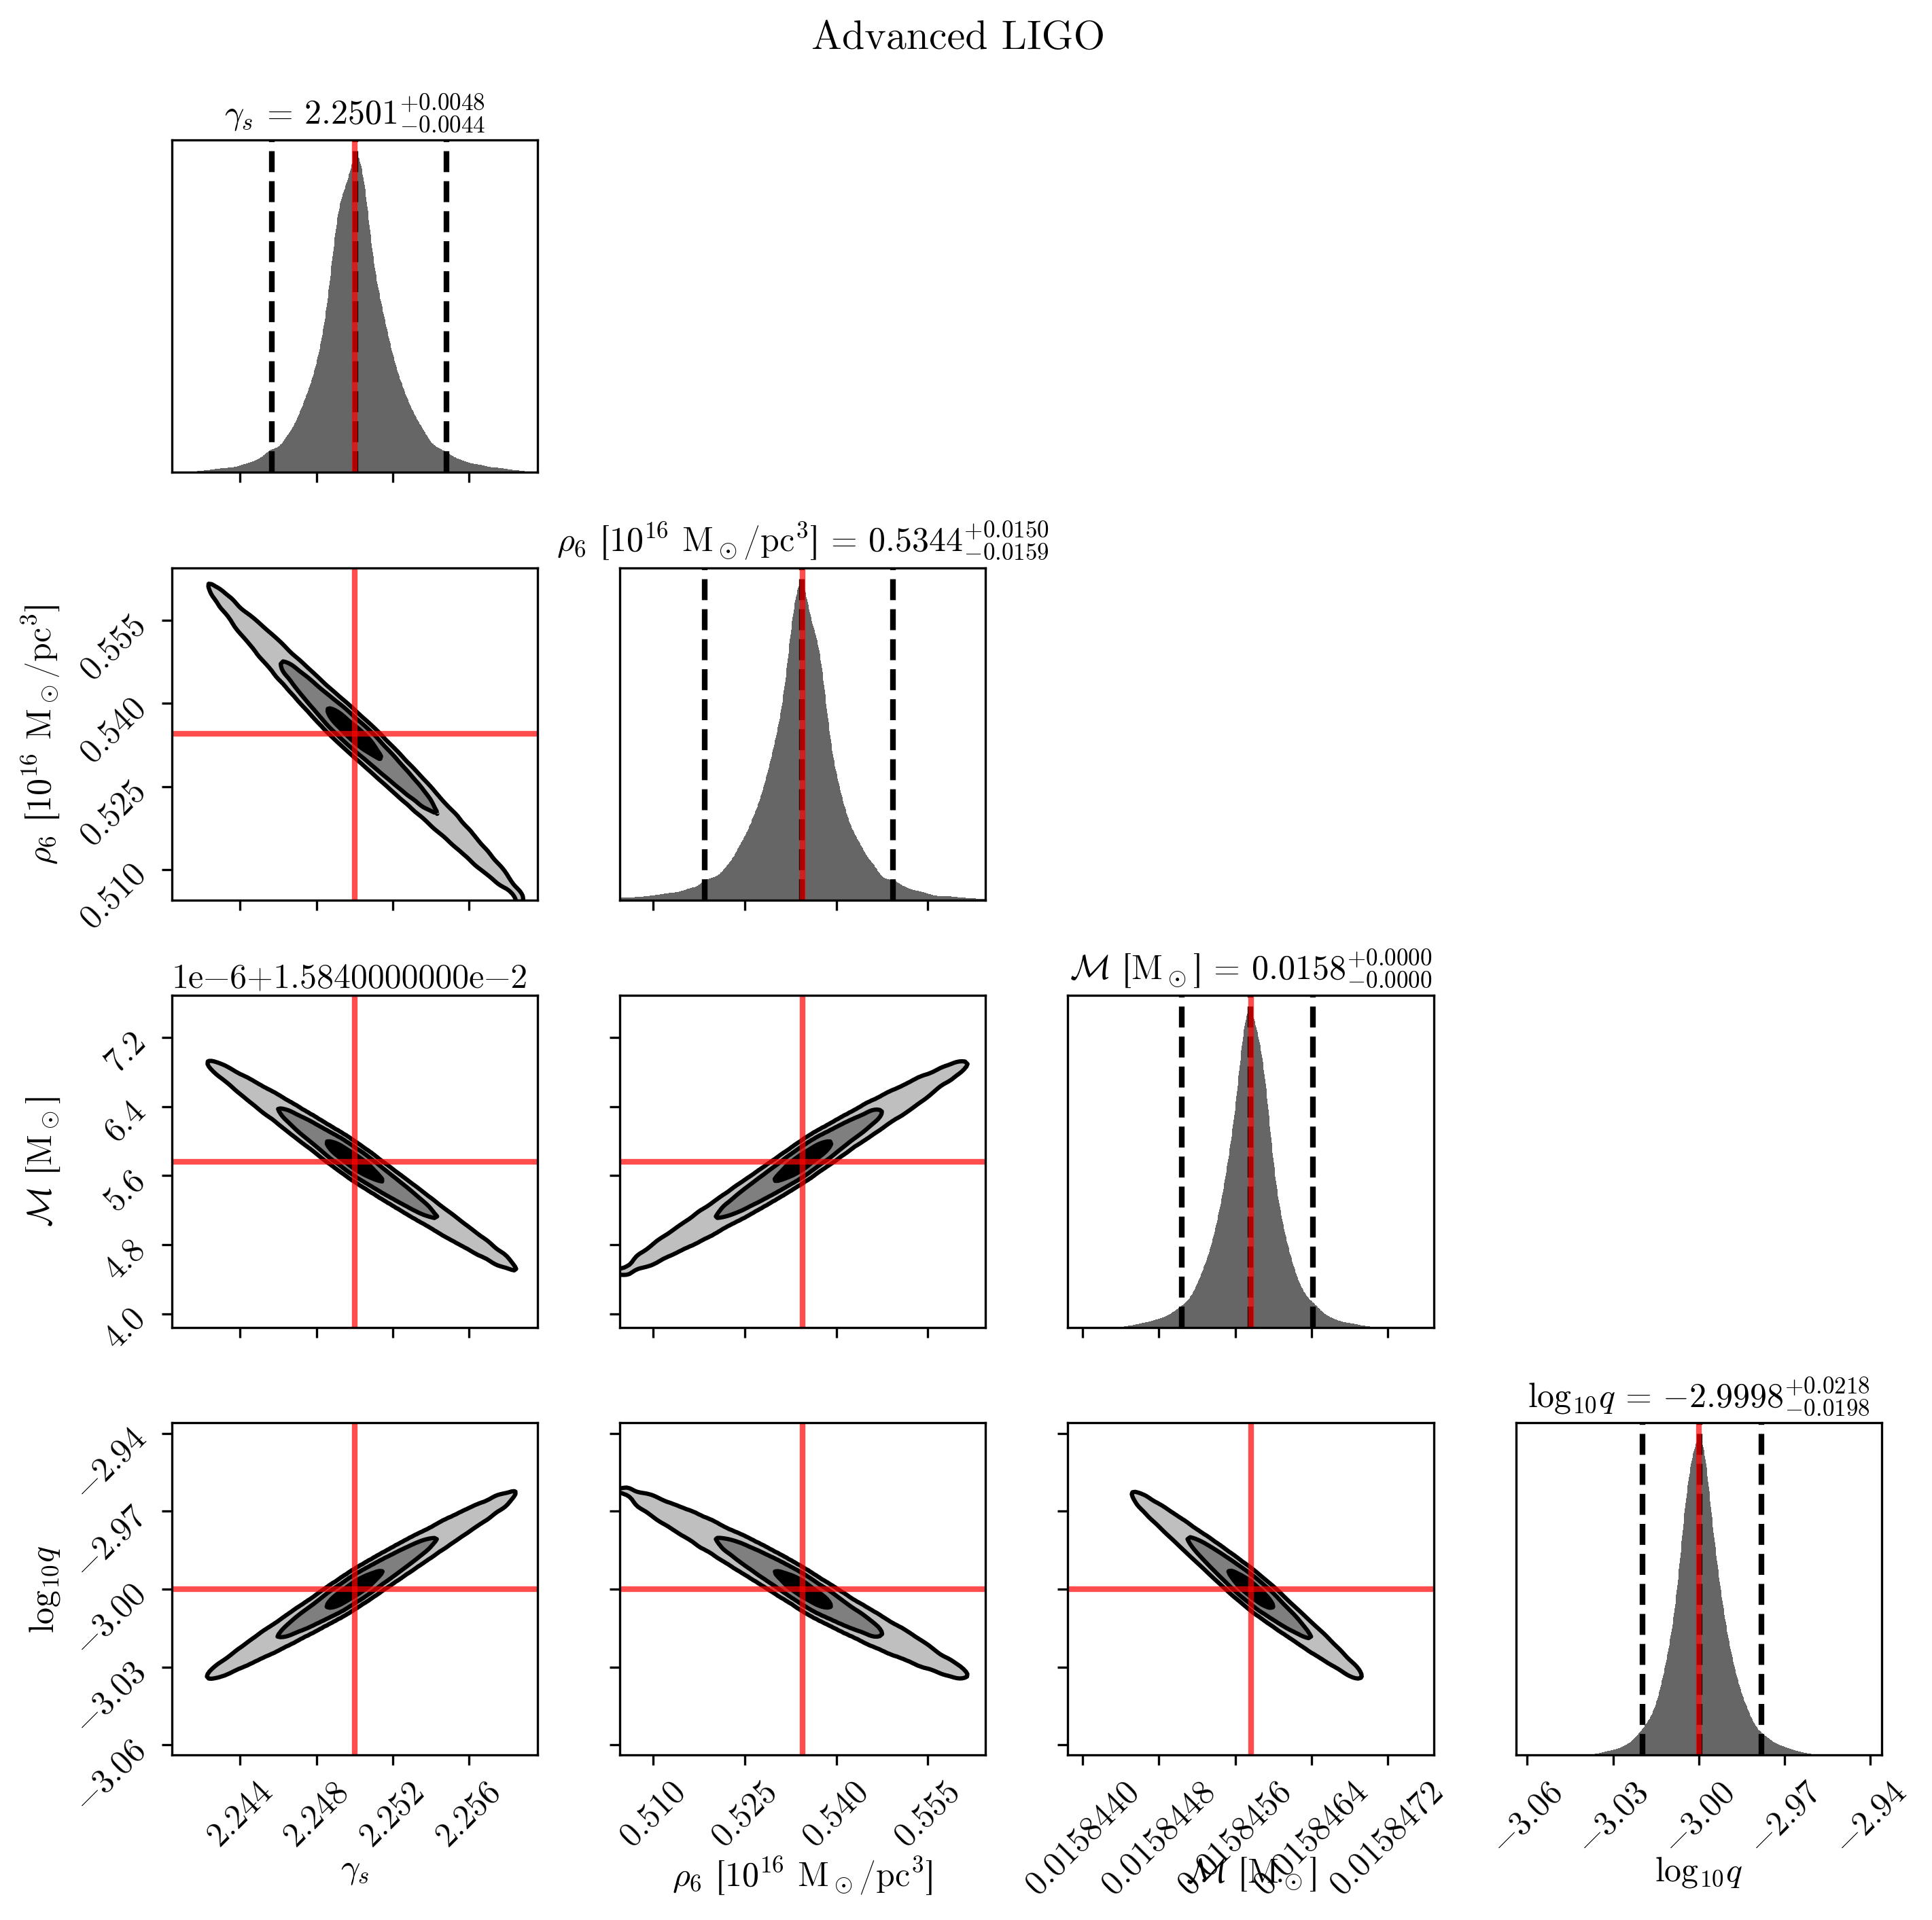

In [93]:
labels = (
    r"$\gamma_s$",
    r"$\rho_6$ [$10^{16}$ M$_\odot$/pc$^3$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
truths = (
    DD_D.gamma_s,
    DD_D.rho_6 / (1e16 * MSUN / PC ** 3),
    DD_D.M_chirp / MSUN,
    jnp.log10(DD_D.q),
)
fig, axes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=quantiles_2d,
    smooth=0.015,
    truths=truths,
    span=(1, 1, 1, 1),
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".4f"
)
fig.suptitle("Advanced LIGO")
fig.tight_layout()
fig.savefig("figures/ns-aLIGO.pdf")